In [1]:
# Cell 1: General code cell.




# Outlines:
- [0-Introduction](#0)
- [1- Import Data and Packages](#1)
- [2- Feature Extraction](#2)
- [3- EDA](#3)
    - [3.1 - Scatter matrix](#3.1)
    - [3.2 - Univariate Analysis](#3.2)
    - [3.3 - Plotting Colinearity](#3.3)
    - [3.4 - Numerical Columns over the date columns](#3.4)
- [4- Preprocessing and Transformers](#4)
    - [4.1- Pipeline](#4.1)
- [5- Feature Importance](#5)
- [6- Modeling](#6)
    - [6.1 - Plot Model Scores](#6.1)
    - [6.2 - Final Model](#6.2)
    - [6.3 - Cross-Validation Scores](#6.3)
- [7- Plot Real/Predicted/Actual Power](#7)

<a name="0"></a>
# Introduction
#### In the modern era, wind turbines have emerged as pivotal components of the global energy landscape. Operating on a straightforward principle, these turbines harness the kinetic energy of the wind to rotate blades connected to a rotor, ultimately driving a generator that produces electricity. This clean and renewable energy source has experienced remarkable growth, with wind power capacity rapidly expanding across continents.
The environmental advantages of wind turbines are profound. They generate no greenhouse gas emissions or air pollutants during operation, making them indispensable in efforts to combat climate change and diminish dependence on fossil fuels. Additionally, wind energy is abundant and everlasting, offering a reliable power source for future generations.

### About Dataset
In Wind Turbines, SCADA Systems measure and save data such as wind speed, wind direction, generated power, etc. at 10-minute intervals. This file contains data from a wind turbine's SCADA system that is operational and generating power in Turkey.

### Content
#### The data in the file includes:

* Date/Time (for 10-minute intervals)
* LV ActivePower (kW): The power generated by the turbine for that moment
* Wind Speed (m/s): The wind speed at the hub height of the turbine (the wind speed that the turbine uses for electricity generation)
* Theoretical Power Curve (KWh): The theoretical power values that the turbine generates with that wind speed, which is provided by the turbine manufacturer
* Wind Direction (°): The wind direction at the hub height of the turbine (wind turbines automatically turn to this direction)

In [2]:
# Cell 5: Set up environment and import libraries.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
# Attempting to use TensorFlow
warnings.simplefilter("ignore")

In [3]:
# Cell 6: Load dataset(s) from disk into memory.

df = pd.read_csv('data/T1.csv')
df

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
0,01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904
1,01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113
2,01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789
3,01 01 2018 00:30,419.645905,5.659674,516.127569,271.258087
4,01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286
...,...,...,...,...,...
50525,31 12 2018 23:10,2963.980957,11.404030,3397.190793,80.502724
50526,31 12 2018 23:20,1684.353027,7.332648,1173.055771,84.062599
50527,31 12 2018 23:30,2201.106934,8.435358,1788.284755,84.742500
50528,31 12 2018 23:40,2515.694092,9.421366,2418.382503,84.297913


In [4]:
# Cell 7: General code cell.

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50530 entries, 0 to 50529
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Date/Time                      50530 non-null  object 
 1   LV ActivePower (kW)            50530 non-null  float64
 2   Wind Speed (m/s)               50530 non-null  float64
 3   Theoretical_Power_Curve (KWh)  50530 non-null  float64
 4   Wind Direction (°)             50530 non-null  float64
dtypes: float64(4), object(1)
memory usage: 1.9+ MB


In [5]:
# Cell 8: General code cell.

df.describe()

,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
count,50530.000000,50530.000000,50530.000000,50530.000000
mean,1307.684332,7.557952,1492.175463,123.687559
std,1312.459242,4.227166,1368.018238,93.443736
min,-2.471405,0.000000,0.000000,0.000000
25%,50.677890,4.201395,161.328167,49.315437
50%,825.838074,7.104594,1063.776283,73.712978
75%,2482.507568,10.300020,2964.972462,201.696720
max,3618.732910,25.206011,3600.000000,359.997589


In [6]:
#There is negative values in the actual power column
count_negative_values = (df['LV ActivePower (kW)'] < 0).sum()
count_negative_values

np.int64(57)

In [7]:
# Cell 10: SCADA-specific logic and fault detection steps.

df.loc[df['LV ActivePower (kW)'] < 0, 'LV ActivePower (kW)'] = 0

<a name="2"></a>
# 2 - Feature Extraction
#### Extract new features from the Date/Time Column

In [8]:
#Save a copy for the pipeline and split it
df_copy=df.copy()

In [9]:
# Cell 13: General code cell.

df['Date/Time']=pd.to_datetime(df['Date/Time'],format='%d %m %Y %H:%M')

In [10]:
# Cell 14: General code cell.

df['Week']=df['Date/Time'].dt.day // 7 + 1

df['Week'].value_counts()

Week
3    11948
4    11809
2    11645
1     9924
5     5204
Name: count, dtype: int64

In [11]:
# Cell 15: General code cell.

df['Month']=df['Date/Time'].dt.month

In [12]:
# Cell 16: General code cell.

seasons_dict = {1: 'Winter', 2: 'Winter', 3: 'Spring', 4: 'Spring', 5: 'Spring', 6: 'Summer', 7: 'Summer', 8: 'Summer', 9: 'Autumn', 10: 'Autumn', 11: 'Autumn', 12: 'Winter'}
df['Seasons'] = df['Month'].map(seasons_dict)

In [13]:
# Cell 17: General code cell.

df['Day']=df['Date/Time'].dt.day

In [14]:
# Cell 18: General code cell.

df['Hour']=df['Date/Time'].dt.hour+1

In [15]:
# Cell 19: General code cell.

df.drop(columns=['Date/Time'],inplace=True)

In [16]:
# Cell 20: Clean and preprocess data (impute, encode, scale, split).

df.isna().sum()

LV ActivePower (kW)              0
Wind Speed (m/s)                 0
Theoretical_Power_Curve (KWh)    0
Wind Direction (°)               0
Week                             0
Month                            0
Seasons                          0
Day                              0
Hour                             0
dtype: int64

Split The Data¶

In [17]:
# Cell 22: Clean and preprocess data (impute, encode, scale, split).

from sklearn.model_selection import train_test_split
df_train,df_test=train_test_split(df,test_size=0.2,random_state=42)
df_copy_train,df_copy_test=train_test_split(df_copy,test_size=0.2,random_state=42)

<a name="3"></a>
# 3 - EDA

In [18]:
#Intialize Numerical and Date Columns
date_col=['Week','Month','Seasons','Hour','Day']
num_col=['LV ActivePower (kW)', 'Wind Speed (m/s)', 'Theoretical_Power_Curve (KWh)', 'Wind Direction (°)',]

array([[<Axes: title={'center': 'LV ActivePower (kW)'}>,
        <Axes: title={'center': 'Wind Speed (m/s)'}>],
       [<Axes: title={'center': 'Theoretical_Power_Curve (KWh)'}>,
        <Axes: title={'center': 'Wind Direction (°)'}>]], dtype=object)

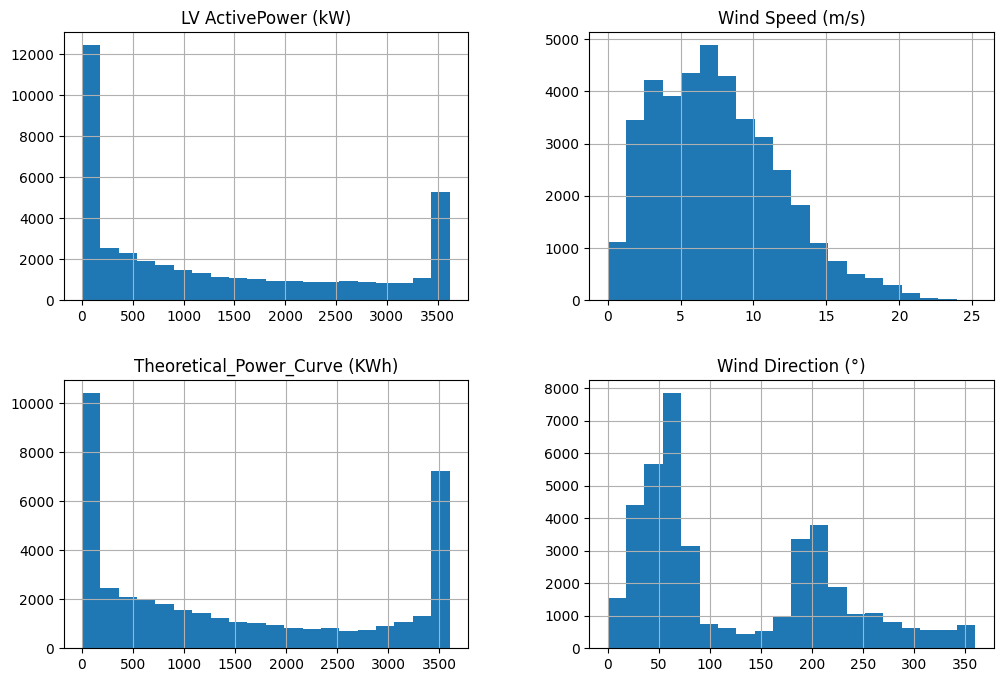

In [19]:
# Cell 25: Plot charts/figures for data or results.

df_train[num_col].hist(bins=20,figsize=(12,8))

<a name="3.1"></a>
## 3.1 - Scatter matrix

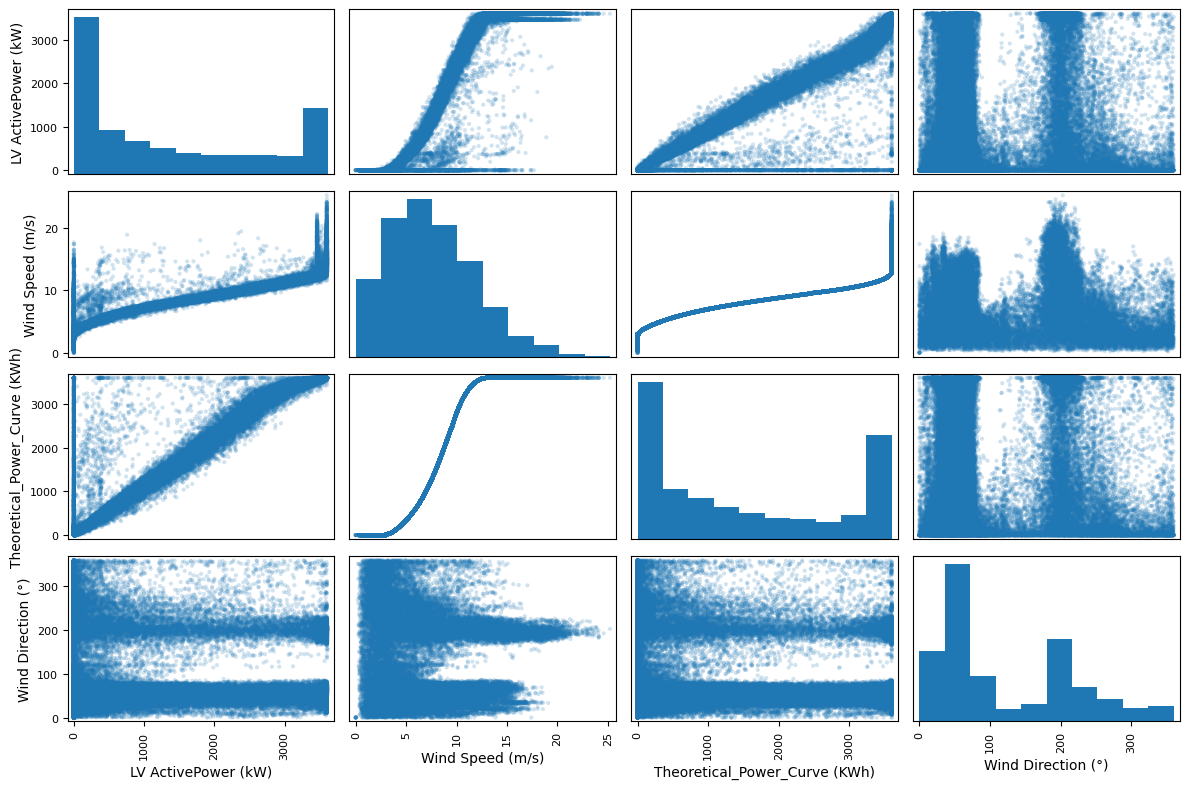

In [20]:
# Cell 27: Plot charts/figures for data or results.

pd.plotting.scatter_matrix(df[num_col], alpha=0.2, figsize=(12, 8))
plt.tight_layout()
plt.show()

* Comments:
    * from the scatter plot between wind speed and Theoritical Power Curve, we see that Wind Turbines Systems can't generate any power if the wind speed is less than 4 m/s
    * when the wind speed is larger than 4 m/s to 11 m/s, the relation between them are linear meaning that increasing the wind speed, allows turbines to generate more power
    * after the wind speed passes 11 m/s, the power generated is saturated on 3600 KWh

<a name="3.2"></a>
## 3.2 - Univariate Analysis

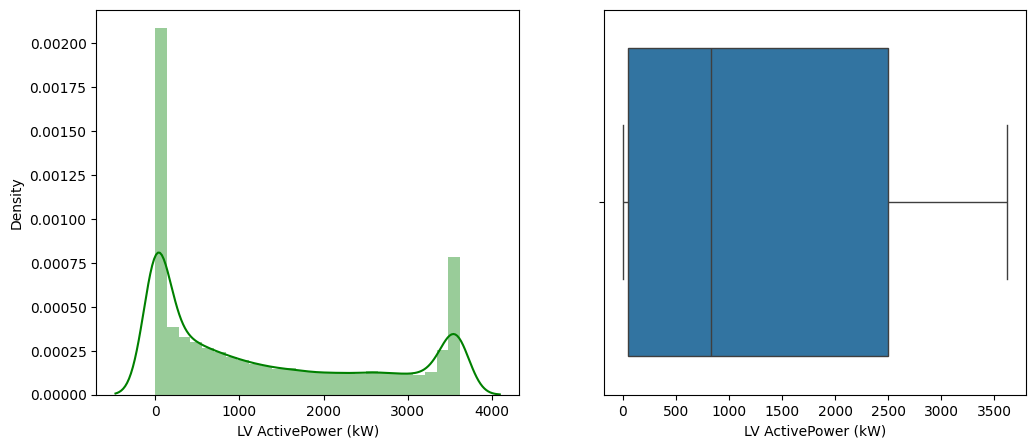

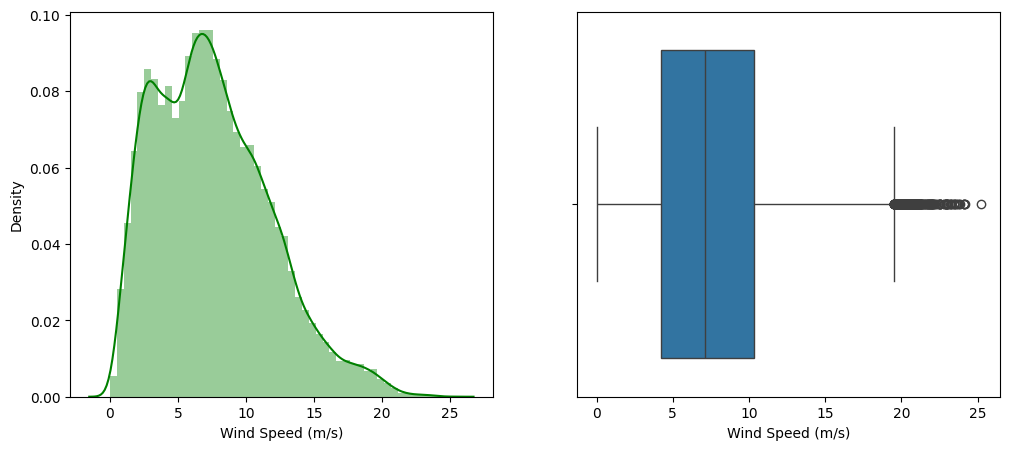

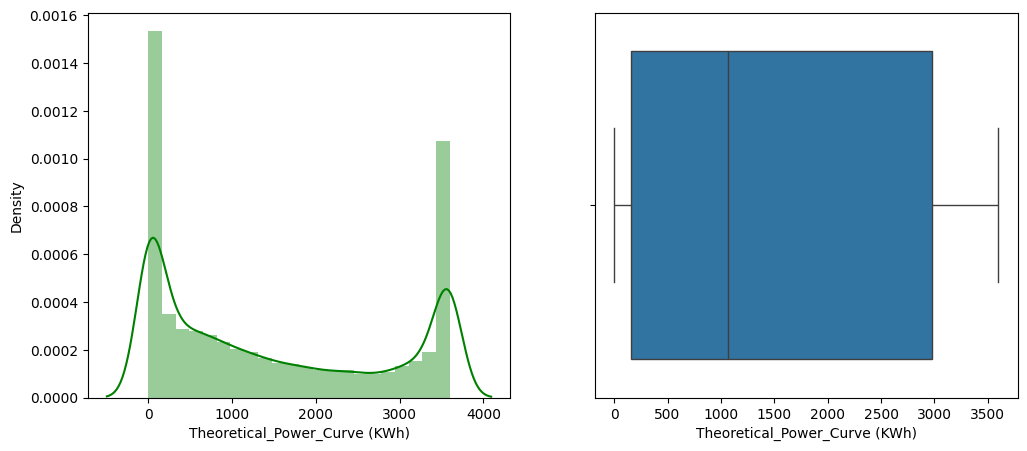

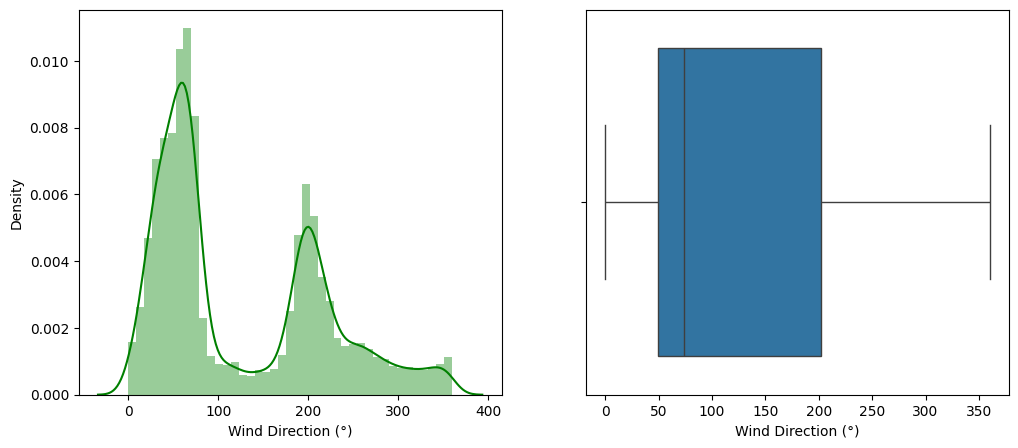

In [21]:
# Cell 30: Plot charts/figures for data or results.

for col in num_col:
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    sns.distplot(df_train[col], ax=ax[0] ,color='green')  
    sns.boxplot(x=df_train[col], ax=ax[1])
    plt.show()

<a name="3.3"></a>
## 3.3 - Plotting Colinearity

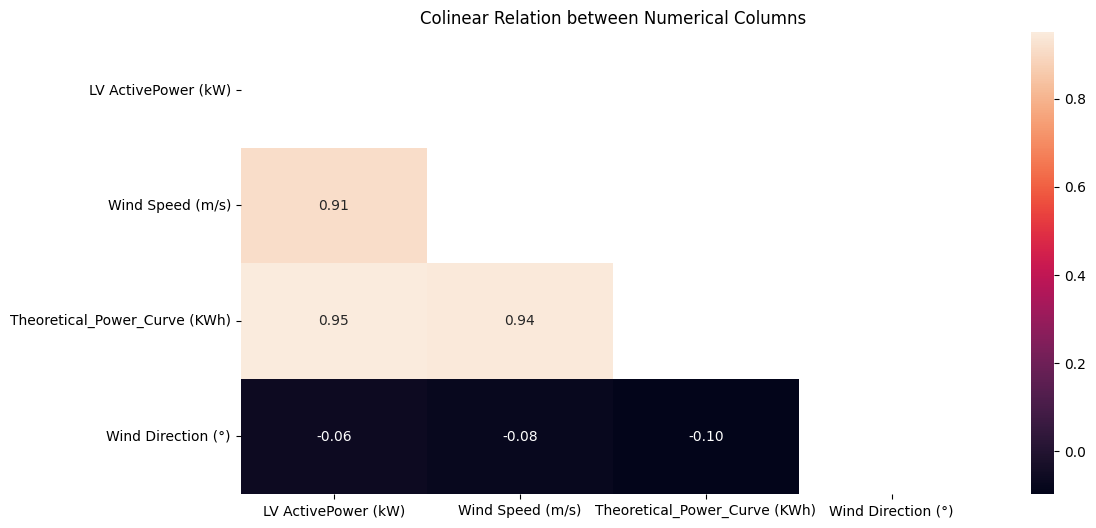

In [22]:
# Cell 32: Plot charts/figures for data or results.

corr = df_train[num_col].corr(numeric_only=True)
mask = np.triu(corr)
mask=mask
plt.figure(figsize=(12, 6))
plt.title('Colinear Relation between Numerical Columns')
sns.heatmap(corr, annot=True,mask=mask, fmt='.2f')
sns.color_palette("magma", as_cmap=True)
plt.show()

<a name="3.4"></a>
## 3.4 - Numerical Columns over the date columns
#### Numerical Columns over the Weeks

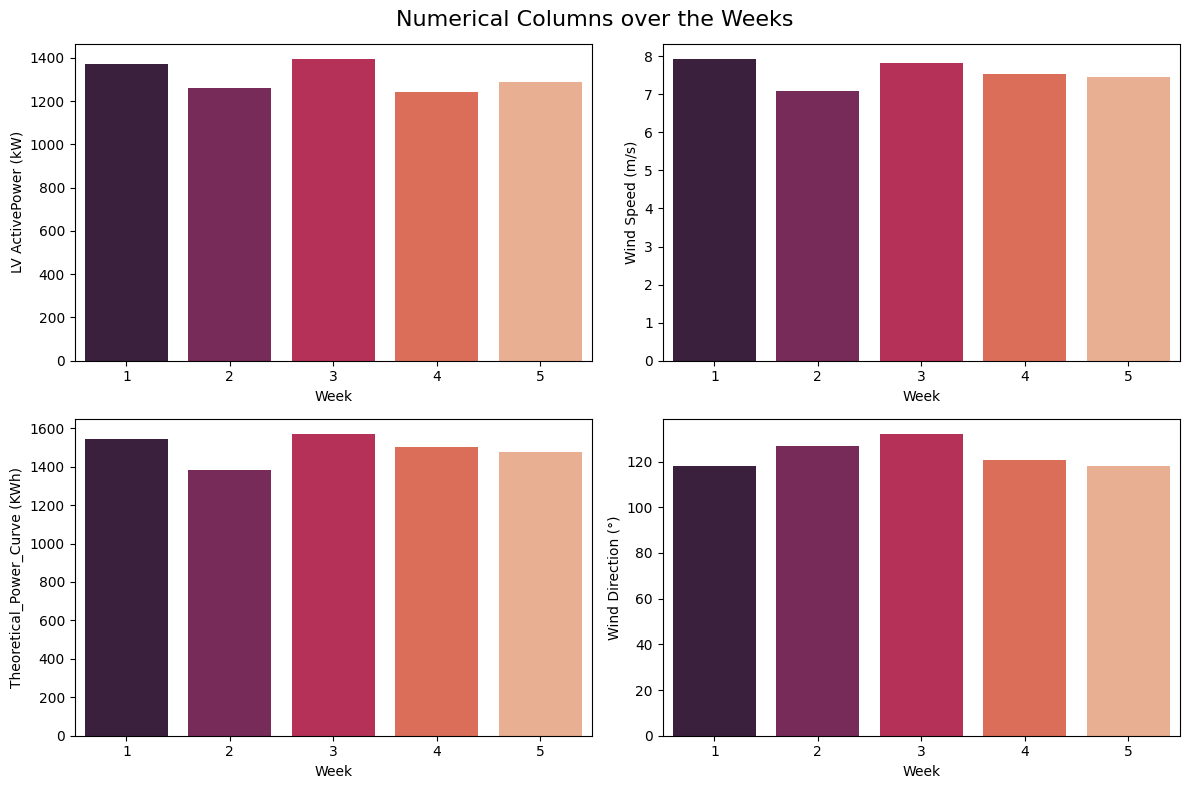

In [23]:
# Cell 34: Plot charts/figures for data or results.

fig,axes=plt.subplots(nrows=len(num_col)//2 ,ncols=2,figsize=(12,8))
for idx,col in enumerate(df_train[num_col]):
    row_idx=idx//2
    col_idx=idx%2
    sns.barplot(x=df_train['Week'],y=df_train[col],data=df_train,ax=axes[row_idx,col_idx],errorbar=None,palette='rocket')
fig.suptitle('Numerical Columns over the Weeks', fontsize=16)
plt.tight_layout()
plt.show() 

### Numerical Columns for each Month

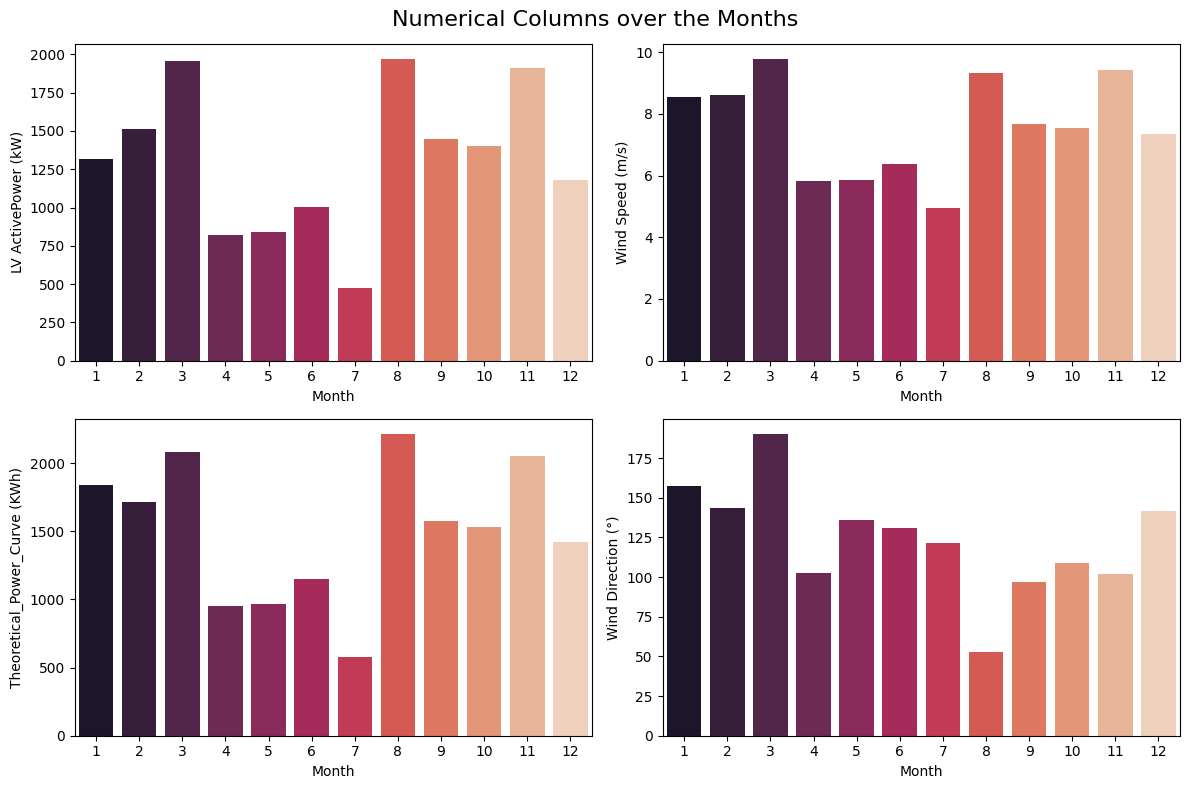

In [24]:
# Cell 36: Plot charts/figures for data or results.

fig,axes=plt.subplots(nrows=len(num_col)//2 ,ncols=2,figsize=(12,8))
for idx,col in enumerate(df_train[num_col]):
    row_idx=idx//2
    col_idx=idx%2
    sns.barplot(x=df_train['Month'],y=df_train[col],data=df_train,ax=axes[row_idx,col_idx],errorbar=None,palette='rocket')
fig.suptitle('Numerical Columns over the Months', fontsize=16)
plt.tight_layout()
plt.show() 

### Numerical Columns over the Seasons

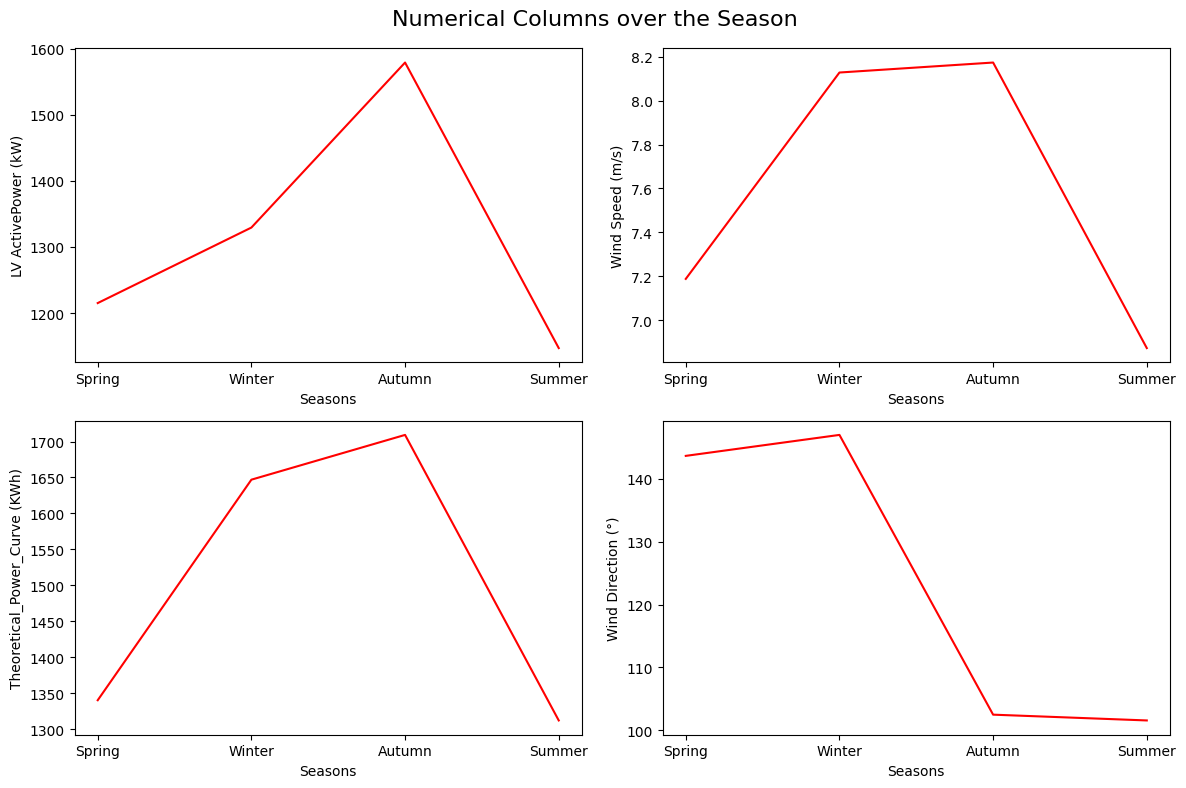

In [25]:
# Cell 38: Plot charts/figures for data or results.

fig,axes=plt.subplots(nrows=len(num_col)//2 ,ncols=2,figsize=(12,8))
for idx,col in enumerate(df_train[num_col]):
    row_idx=idx//2
    col_idx=idx%2
    sns.lineplot(x='Seasons',y=df_train[col],data=df_train,ax=axes[row_idx,col_idx],ci=None,color='red')
fig.suptitle('Numerical Columns over the Season', fontsize=16)
plt.tight_layout()
plt.show() 

In [26]:
# # --- QUYẾT ĐỊNH XỬ LÝ DỮ LIỆU NGOÀI PIPELINE ---
# # Dựa trên phân tích EDA, chúng ta xác định các điểm dữ liệu có thể là trạng thái "bảo trì"
# # (Power = 0 dù có gió mạnh) và loại bỏ chúng ra khỏi TẬP HUẤN LUYỆN.

# print(f"Số lượng bản ghi trong tập huấn luyện TRƯỚC khi lọc: {len(df_copy_train)}")

# # Tạo một mask để xác định các điểm "bảo trì" trong tập huấn luyện
# # Chú ý: Chúng ta chỉ lọc trên df_copy_train, không đụng đến df_copy_test
# maintenance_mask = (df_copy_train['LV ActivePower (kW)'] == 0) & (df_copy_train['Wind Speed (m/s)'] > 4)

# # Lọc bỏ các điểm này. Dấu ~ có nghĩa là "phủ định" (NOT)
# df_copy_train = df_copy_train[~maintenance_mask]

# print(f"Số lượng bản ghi trong tập huấn luyện SAU khi lọc: {len(df_copy_train)}")

# # Bây giờ, khi Cell 42 chạy, X_train và y_train sẽ được tạo ra từ bộ df_copy_train đã được lọc sạch.
# # Tập test (df_copy_test) được giữ nguyên để mô phỏng dữ liệu thực tế, có thể chứa cả trạng thái bảo trì.

<a name="4"></a>
# 4 - Preprocessing

In [27]:
# Cell 40: Clean and preprocess data (impute, encode, scale, split).

from sklearn.preprocessing import LabelEncoder, Normalizer, StandardScaler, MinMaxScaler, RobustScaler,OneHotEncoder,OrdinalEncoder
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score,mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer,KNNImputer
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.ensemble import RandomForestRegressor

### Split the Target and Label Columns

In [28]:
# Cell 42: SCADA-specific logic and fault detection steps.

X_train,y_train,X_test,y_test=df_copy_train.drop(columns='LV ActivePower (kW)'),df_copy_train['LV ActivePower (kW)'],df_copy_test.drop(columns='LV ActivePower (kW)'),df_copy_test['LV ActivePower (kW)']

In [29]:
# Cell 43: General code cell.

print("The Shape of X_train is :",X_train.shape)
print("The Shape of y_train is :",y_train.shape)
print("The Shape of X_test is :",X_test.shape)
print("The Shape of y_test is :",y_test.shape)

The Shape of X_train is : (40424, 4)
The Shape of y_train is : (40424,)
The Shape of X_test is : (10106, 4)
The Shape of y_test is : (10106,)


<a name="4.1"></a>
# 4.1 - Custom Transformers & Pipeline

In [30]:
# Cell 45: Clean and preprocess data (impute, encode, scale, split).

class StandardScaleTransform(BaseEstimator, TransformerMixin):
    """
    A transformer class to apply standard scaling to specified columns in a Pandas DataFrame.

    Parameters
    ----------
    cols : list of str
        The names of the columns to apply standard scaling to.
    """
    def __init__(self, cols):
        self.cols = cols
        self.scaler_ = None

    def fit(self, X, y=None):
        self.scaler_ = StandardScaler().fit(X.loc[:, self.cols])
        return self

    def transform(self, X):
        X_copy = X.copy()
        X_copy.loc[:, self.cols] = self.scaler_.transform(X_copy.loc[:, self.cols])
        return X_copy

    def fit_transform(self, X, y=None):
        self.scaler_ = StandardScaler().fit(X.loc[:, self.cols])
        return self.transform(X)

In [31]:
# Cell 46: Clean and preprocess data (impute, encode, scale, split).

class DataFrameImputer(TransformerMixin, BaseEstimator):
    """
    A class to impute missing values in a Pandas DataFrame using a combination of median, knn, and most frequent
    imputers on specified columns.

    Parameters:
    -----------
    median_cols : list of str, optional (default=None)
        Columns to impute missing values using the median imputer.
    knn_cols : list of str, optional (default=None)
        Columns to impute missing values using the KNN imputer.

    Returns:
    --------
    X_imputed : pandas.DataFrame
        A DataFrame with imputed missing values.
    """
    def __init__(self, median_cols=None, knn_cols=None):
        self.median_cols = median_cols
        self.knn_cols = knn_cols
    
    def fit(self, X, y=None):
        self.median_imputer = SimpleImputer(strategy='median')
        self.knn_imputer = KNNImputer()

        if self.median_cols is not None:
            self.median_imputer.fit(X[self.median_cols])
        if self.knn_cols is not None:
            self.knn_imputer.fit(X[self.knn_cols])
        return self
    
    def transform(self, X):
        X_imputed = X.copy()
        if self.median_cols is not None:
            X_median = pd.DataFrame(self.median_imputer.transform(X[self.median_cols]), 
                                    columns=self.median_cols, index=X.index)
            X_imputed = pd.concat([X_imputed.drop(self.median_cols, axis=1), X_median], axis=1)
        if self.knn_cols is not None:
            X_knn = pd.DataFrame(self.knn_imputer.transform(X[self.knn_cols]), 
                                 columns=self.knn_cols, index=X.index)
            X_imputed = pd.concat([X_imputed.drop(self.knn_cols, axis=1), X_knn], axis=1)
        return X_imputed
    
    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)

In [32]:
# Cell 47: Train machine learning model(s).

class DateExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, date_cols):
        self.date_cols = date_cols
         

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        extracted_features = []
        for col in self.date_cols:
            dates = pd.to_datetime(X[col], format='%d %m %Y %H:%M')
            for date in dates:
                month_val = date.month
                week_val = date.day // 7 + 1
                day_val = date.day
                hour_val = date.hour + 1
                # Determining season based on month
                if month_val in [3, 4, 5]:
                    season_val = 'Spring'
                elif month_val in [6, 7, 8]:
                    season_val = 'Summer'
                elif month_val in [9, 10, 11]:
                    season_val = 'Autumn'
                else:
                    season_val = 'Winter'
                extracted_features.append([month_val, week_val, day_val, season_val, hour_val])

        # Convert the extracted features list to a DataFrame
        X_date = pd.DataFrame(extracted_features, columns=['Month', 'Week', 'Day', 'Season', 'Hour'])
        X_new=pd.concat([X.reset_index(drop=True),X_date],axis=1)
        return X_new
    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)

In [33]:
# Cell 48: Train machine learning model(s).

# class OutlierThresholdTransformer(BaseEstimator, TransformerMixin):
#     def __init__(self, column, q1=0.25, q3=0.75):
#         self.column = column
#         self.q1 = q1
#         self.q3 = q3
#     def outlier_threshhold(self, dataframe, column):
#         Q1 = dataframe[column].quantile(self.q1)
#         Q3 = dataframe[column].quantile(self.q3)
#         iqr = Q3 - Q1
#         up_limit = Q3 + 1.5 * iqr
#         low_limit = Q1 - 1.5 * iqr
#         return low_limit, up_limit

#     def fit(self, X, y=None):
#         return self

#     def transform(self, X):
#         X_copy = X.copy()
#         for col in self.column:
#             low_limit, up_limit = self.outlier_threshhold(X_copy, col)
#             X_copy.loc[(X_copy[col] < low_limit), col] = low_limit
#             X_copy.loc[(X_copy[col] > up_limit), col] = up_limit
#         return X_copy

#     def fit_transform(self, X, y=None):
#         return self.transform(X)
class OutlierThresholdTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column, q1=0.25, q3=0.75):
        self.column = column
        self.q1 = q1
        self.q3 = q3
        self.thresholds_ = {}  # will store per-column thresholds

    def fit(self, X, y=None):
        self.thresholds_ = {}
        for col in self.column:
            Q1 = X[col].quantile(self.q1)
            Q3 = X[col].quantile(self.q3)
            iqr = Q3 - Q1
            up_limit = Q3 + 1.5 * iqr
            low_limit = Q1 - 1.5 * iqr
            self.thresholds_[col] = (low_limit, up_limit)
        return self

    def transform(self, X):
        X_copy = X.copy()
        for col in self.column:
            low_limit, up_limit = self.thresholds_[col]
            X_copy.loc[X_copy[col] < low_limit, col] = low_limit
            X_copy.loc[X_copy[col] > up_limit, col] = up_limit
        return X_copy


In [34]:
# Cell 49: Train machine learning model(s).

class DropColumnsTransformer(BaseEstimator, TransformerMixin):
    """
    A transformer that drops specified columns from a DataFrame.

    Parameters
    ----------
    columns : list
        A list of column names to be dropped.
    return
    ------
        dataframe with dropped columns
    """
    def __init__(self, columns=None):
        self.columns = columns
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if self.columns is None:
            return X
        else:
            return X.drop(self.columns,axis=1)

In [35]:
# Cell 50: Clean and preprocess data (impute, encode, scale, split).

class CustomOneHotEncoder(BaseEstimator, TransformerMixin):

    """
    A transformer class to apply one-hot encoding to specified columns in a Pandas DataFrame.

    Parameters
    ----------
    columns : list
        A list of column names to encode.

    Returns
    -------
    pandas.DataFrame
        A new DataFrame with the specified columns one-hot encoded.
    """
    def __init__(self, columns=None):
        self.columns = columns
        self.unique_values = {} 
        self.feature_names_ = None

    def fit(self, X, y=None):
        if self.columns is None:
            self.columns = X.columns.tolist() 
        self.unique_values = {col: X[col].unique() for col in self.columns}
        self.feature_names_ = self._get_feature_names()
        return self
    def _get_feature_names(self):
        feature_names = []
        for col in self.columns:
            for value in self.unique_values[col]:
                feature_names.append(f"{col}_{value}")
        return feature_names
    def transform(self, X):
        X_transformed = pd.DataFrame(index=X[self.columns].index)
                                     
        for col in self.columns:
            for value in self.unique_values[col]:
                X_transformed[f"{col}_{value}"] = (X[col] == value).astype(int)
        
        X = pd.concat([X, X_transformed], axis=1)
        return X.drop(columns=['Season'])
    
    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)

In [36]:
# Cell 51: Clean and preprocess data (impute, encode, scale, split).

class LabelEncodeColumns(BaseEstimator, TransformerMixin):
    """
    A transformer class to encode categorical columns using LabelEncoder.

    Parameters
    ----------
    columns : list of str
        The names of the columns to be encoded.

    return
    ------
        encoded feature
    """
    def __init__(self, columns):
        self.columns = columns
        self.encoders_ = {}

    def fit(self, X, y=None):
        for col in self.columns:
            encoder = LabelEncoder()
            encoder.fit(X[col])
            self.encoders_[col] = encoder
        return self

    def transform(self, X):
        X_copy = X.copy()
        for col, encoder in self.encoders_.items():
            X_copy[col] = encoder.transform(X_copy[col])
        return X_copy

    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X)

In [37]:
# Cell 52: Clean and preprocess data (impute, encode, scale, split).

class FullPipeline1:
    def __init__(self) :
        self.date_cols=['Date/Time']
        self.numerical_cols=['Wind Speed (m/s)', 'Theoretical_Power_Curve (KWh)', 'Wind Direction (°)','Week','Month','Hour','Day']
        self.MLE_cols=['Season']
        self.full_pipeline=Pipeline([
            ('extract_date',DateExtractor(date_cols=self.date_cols)),
            ('label_encode', CustomOneHotEncoder(columns=self.MLE_cols)),
            #('label_encode', LabelEncodeColumns(columns=self.MLE_cols)),
            ('impute_num',DataFrameImputer(knn_cols=self.numerical_cols)),
            ('remove_outlier',OutlierThresholdTransformer(column=self.numerical_cols)),
            ('scale', StandardScaleTransform(cols=self.numerical_cols)),
            ('drop', DropColumnsTransformer(columns=self.date_cols)),
           
        ])
    def fit_transform(self, X_train):
        X_train = self.full_pipeline.fit_transform(X_train)
        return X_train
    def transform(self, X_test):
        X_test = self.full_pipeline.transform(X_test)
        return X_test
f1=FullPipeline1()
X_1_train_f1=f1.fit_transform(X_train)
X_1_test_f1=f1.transform(X_test)

In [38]:
# Cell 53: General code cell.

X_1_train_f1.head()

,Season_Spring,Season_Winter,Season_Autumn,Season_Summer,Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°),Week,Month,Hour,Day
0,1,0,0,0,-1.131041,-1.091661,0.600542,-0.641252,-0.738439,-0.800917,-0.533974
1,0,1,0,0,-0.616778,-0.852852,-0.007299,-1.424629,1.605546,-0.800917,-1.569184
2,0,0,1,0,1.231326,1.531968,0.937698,1.708881,1.019550,0.928508,1.651468
3,0,0,0,1,-0.110304,-0.318188,-0.744266,-1.424629,-0.152443,-0.368561,-1.684207
4,1,0,0,0,-0.303991,-0.564102,-0.869168,1.708881,-1.031437,0.352033,1.421421


<a name="5"></a>
# 5 - Feature Importance

In [39]:
#Create and train a Random Forest regressor
model=RandomForestRegressor(random_state=42)
model.fit(X_1_train_f1,y_train)
feature_importance=model.feature_importances_
#Create a DataFrame to associate feature names with their importances
feature_importance_df=pd.DataFrame({'Feature':X_1_train_f1.columns,'Importance':feature_importance})
#Sort feature by importance
feature_importance_df=feature_importance_df.sort_values(by='Importance',ascending=False)

In [40]:
# Cell 56: Clean and preprocess data (impute, encode, scale, split).

feature_importance_df

,Feature,Importance
4,Wind Speed (m/s),0.467188
5,Theoretical_Power_Curve (KWh),0.453834
6,Wind Direction (°),0.025089
10,Day,0.023817
8,Month,0.013416
9,Hour,0.008390
1,Season_Winter,0.003750
7,Week,0.003392
3,Season_Summer,0.000563
2,Season_Autumn,0.000319


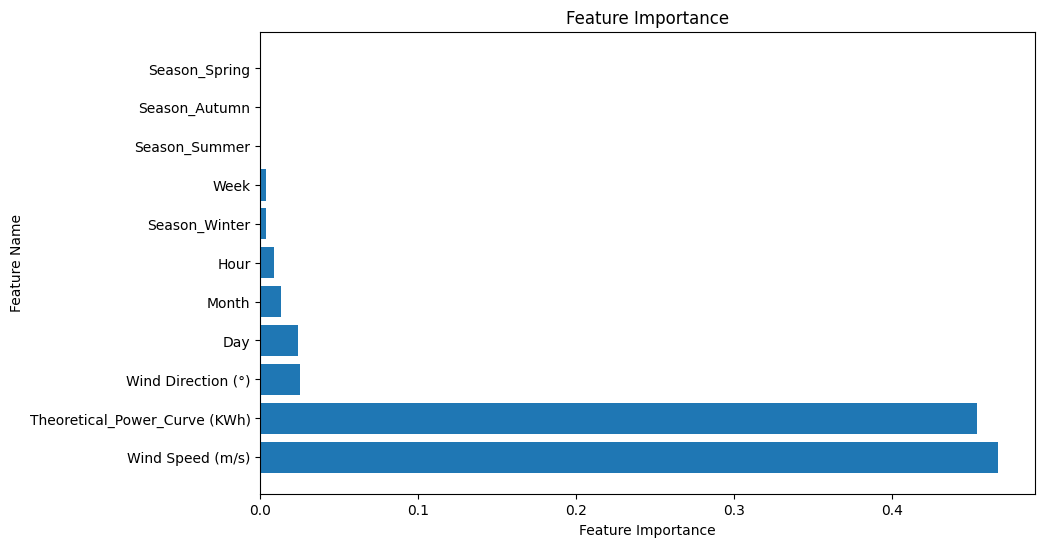

In [41]:
# Cell 57: Plot charts/figures for data or results.

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Feature Importance')
plt.show()

<a name="6"></a>
# 6 - Modeling

In [42]:
# Cell 59: Set up environment and import libraries.

from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor,AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor,XGBRFRegressor
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor

In [43]:
# Cell 60: Train machine learning model(s).

model_name = []
r2score = []
rmse = []
mae=[]
models = [
    GradientBoostingRegressor(random_state=42),
    SVR(),
    RandomForestRegressor(random_state=42),
    LinearRegression(),
    ExtraTreesRegressor(random_state=42),
    AdaBoostRegressor(random_state=42),
    DecisionTreeRegressor(random_state=42),
    XGBRegressor(random_state=42),
    XGBRFRegressor(random_state=42),
    CatBoostRegressor(random_state=42, verbose=False)
]

for model in models:
    model.fit(X_1_train_f1, y_train)
    y_pred = model.predict(X_1_test_f1)

    model_name.append(model.__class__.__name__)
    r2score.append(r2_score(y_test, y_pred) * 100)
    rmse.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    mae.append(str(mean_absolute_error(y_test, y_pred)))

In [44]:
# Cell 61: Clean and preprocess data (impute, encode, scale, split).

# The DataFrame now includes the 'MAE' column
models_df = pd.DataFrame({"Model-Name":model_name, "R2_score": r2score, 'RMSE':rmse, 'MAE': mae})
models_df = models_df.astype({"R2_score": float, "RMSE": float, "MAE": float})
models_df.sort_values("R2_score", ascending = False)

,Model-Name,R2_score,RMSE,MAE
9,CatBoostRegressor,98.254082,172.600073,77.369416
7,XGBRegressor,98.145471,177.887655,76.124406
4,ExtraTreesRegressor,97.739480,196.396263,70.711838
2,RandomForestRegressor,97.398531,210.687276,77.401477
6,DecisionTreeRegressor,95.528001,276.235730,93.217519
0,GradientBoostingRegressor,94.777728,298.509905,132.187312
8,XGBRFRegressor,94.513065,305.980617,127.848887
3,LinearRegression,90.607736,400.326309,205.612457
1,SVR,88.482679,443.307140,256.519930
5,AdaBoostRegressor,86.857825,473.546488,293.146682


<a name="6.1"></a>
## 6.1 - Plot Model Scores

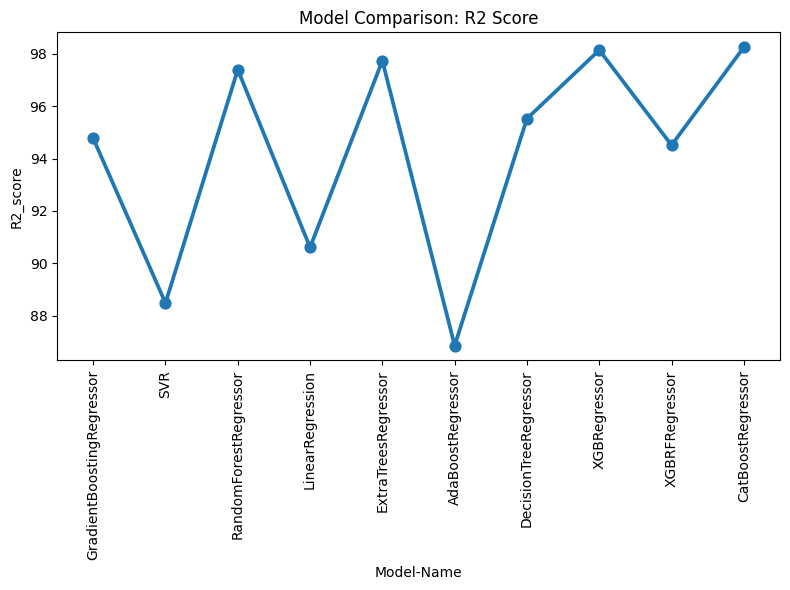

In [45]:
# Cell 63: Plot charts/figures for data or results.

plt.figure(figsize=(8,6))
sns.pointplot(x='Model-Name',y='R2_score',data=models_df)
plt.xticks(rotation=90)
plt.title('Model Comparison: R2 Score')
plt.tight_layout()
plt.show()

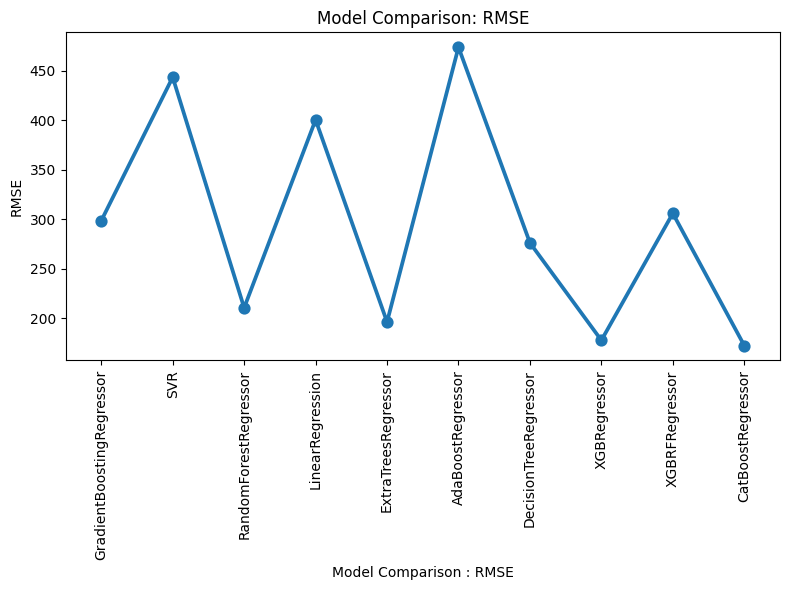

In [46]:
# Cell 64: Plot charts/figures for data or results.

plt.figure(figsize=(8,6))
plt.xlabel('Model Comparison : RMSE')
sns.pointplot(x='Model-Name',y='RMSE',data=models_df)
plt.xticks(rotation=90)
plt.title('Model Comparison: RMSE')
plt.tight_layout()
plt.show()

<a name="6.2"></a>
## 6.2 - Final Model

In [47]:
# Cell 66: Train machine learning model(s).

fm=CatBoostRegressor(random_state=42)

#### Fine Tune your model

In [48]:
#Prepare a set of hyperparameters to search over
param_grid = {
    'learning_rate': np.linspace(0.01, 0.3, 10),
    'iterations': [100, 200, 300, 400, 500],  # Equivalent to n_estimators
    'depth': [3, 5, 7, 9],  # Equivalent to max_depth
    'subsample': np.linspace(0.5, 1.0, 6),
    'colsample_bylevel': np.linspace(0.5, 1.0, 6),  # Equivalent to colsample_bytree
    'l2_leaf_reg': np.linspace(0.01, 1.0, 10),  # Equivalent to reg_lambda
    'min_child_samples': [1, 5, 10, 15],  # Equivalent to min_child_weight 
}

In [49]:
#Create the GridSearchCV object and specify the number of folds for cross-validation
from sklearn.metrics import make_scorer
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)
random_search = RandomizedSearchCV(estimator=fm, param_distributions=param_grid, n_iter=50, scoring=rmse_scorer, n_jobs=-1, error_score='raise', random_state=42)

In [50]:
#Fit the RandmoizedSearch object to your training data:
random_search.fit(X_1_train_f1, y_train, verbose=False)

,estimator,<catboost.cor...001E26388B0E0>
,param_distributions,"{'colsample_bylevel': array([0.5, 0....8, 0.9, 1. ]), 'depth': [3, 5, ...], 'iterations': [100, 200, ...], 'l2_leaf_reg': array([0.01, ..., 0.89, 1. ]), ...}"
,n_iter,50
,scoring,make_scorer(r...hod='predict')
,n_jobs,-1
,refit,True
,cv,None
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,'raise'


In [51]:
#Inspect the best parameters and score:
best_params = random_search.best_params_
best_score = random_search.best_score_
print('Best Parameters: ', best_params)
print('Best RMSE: ', best_score)

Best Parameters:  {'subsample': np.float64(0.8), 'min_child_samples': 1, 'learning_rate': np.float64(0.23555555555555557), 'l2_leaf_reg': np.float64(1.0), 'iterations': 500, 'depth': 9, 'colsample_bylevel': np.float64(0.9)}
Best RMSE:  -147.50171993609666


In [52]:
#Use the best parameters to re-train your model and make predictions on the test data:
best_model = CatBoostRegressor(**best_params)
best_model.fit(X_1_train_f1, y_train,verbose=False)
y_pred = best_model.predict(X_1_test_f1)

In [53]:
# Cell 73: Set up environment and import libraries.

# import joblib
# joblib.dump(f1, 'one_hot_pipeline.pkl')

In [54]:
# Cell 74: Save or load models and artifacts.

# joblib.dump(best_model, 'one_hot_model.pkl')

In [55]:
# Cell 75: General code cell.

y_test1=y_test.to_numpy()

In [56]:
#Evaluate the performance of the best model using your preferred metric
r2 = r2_score(y_test1, y_pred )
print('R2 Score: ', r2)

R2 Score:  0.9878616472188497


In [57]:
# Cell 77: SCADA-specific logic and fault detection steps.

sample_data = {
    'Date/Time': ['31 12 2018 23:10'],
    'Wind Speed (m/s)': [11.404030],
    'Theoretical_Power_Curve (KWh)': [3397.190793],
    'Wind Direction (°)': [80.502724]
}
f_data = pd.DataFrame(sample_data)
f_data1=f1.transform(f_data)
best_model.predict(f_data1)

array([3008.98688487])

<a name="6.3"></a>
## 6.3 - Cross-Validation Scores

In [58]:
# Cell 79: Evaluate model performance and metrics.

cross_val=cross_val_score(best_model,X_1_test_f1,y_test,scoring=rmse_scorer ,cv=20,verbose=False)
print(abs(cross_val))

0:	learn: 1035.4875056	total: 6.16ms	remaining: 3.07s
1:	learn: 829.0757932	total: 12ms	remaining: 2.98s
2:	learn: 674.8831709	total: 18ms	remaining: 2.98s
3:	learn: 557.9546441	total: 23.5ms	remaining: 2.92s
4:	learn: 474.9135844	total: 28.8ms	remaining: 2.85s
5:	learn: 417.3759781	total: 31.8ms	remaining: 2.62s
6:	learn: 377.9013662	total: 36.7ms	remaining: 2.58s
7:	learn: 351.4046922	total: 41.7ms	remaining: 2.56s
8:	learn: 327.9207194	total: 47ms	remaining: 2.56s
9:	learn: 311.1658086	total: 52.8ms	remaining: 2.59s
10:	learn: 294.0607402	total: 59.4ms	remaining: 2.64s
11:	learn: 281.8718912	total: 65.9ms	remaining: 2.68s
12:	learn: 270.6704586	total: 71.8ms	remaining: 2.69s
13:	learn: 261.2767521	total: 78.3ms	remaining: 2.72s
14:	learn: 256.4543067	total: 84.9ms	remaining: 2.74s
15:	learn: 251.6741605	total: 91.1ms	remaining: 2.76s
16:	learn: 244.5351281	total: 97.1ms	remaining: 2.76s
17:	learn: 240.4032611	total: 102ms	remaining: 2.74s
18:	learn: 236.0558648	total: 108ms	remainin

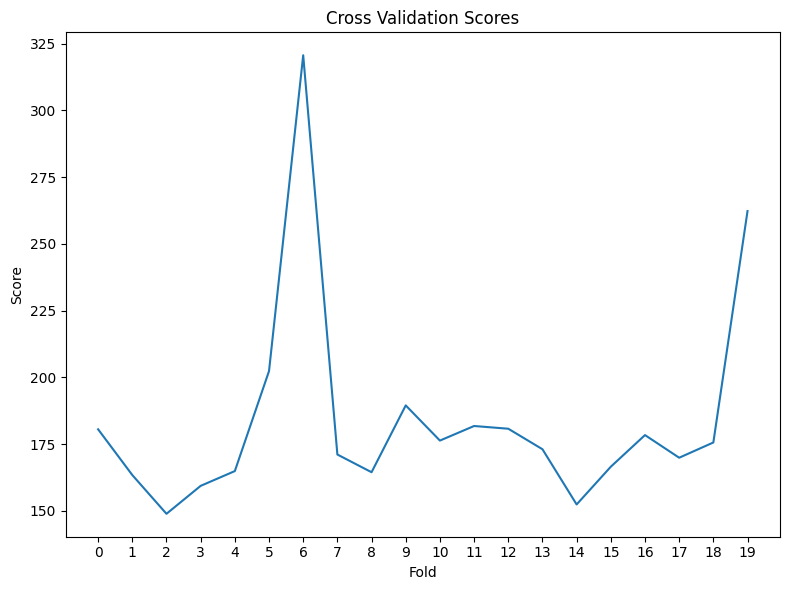

In [59]:
# Cell 80: Plot charts/figures for data or results.

plt.figure(figsize=(8, 6))
plt.plot(abs(cross_val))
plt.title("Cross Validation Scores")
plt.ylabel("Score")
plt.xlabel("Fold")
plt.xticks(np.arange(0,20))
plt.tight_layout()
plt.show()

In [60]:
# Cell 81: Evaluate model performance and metrics.

print(cross_val.max())

-148.8711928958771


In [61]:
# Cell 82: SCADA-specific logic and fault detection steps.

data_new = pd.DataFrame({'LV ActivePower (kW)': y_test})
data_new['Predictions'] = y_pred
data_new["Theoretical_Power_Curve (KWh)"] = df["Theoretical_Power_Curve (KWh)"]

data_new.head()

,LV ActivePower (kW),Predictions,Theoretical_Power_Curve (KWh)
8057,3348.910889,2938.990694,3452.918718
8059,2647.506104,2725.871209,2989.120313
50250,0.000000,37.701979,779.117347
14774,1334.573975,1280.129086,1502.728868
49374,533.002808,531.850327,593.890170


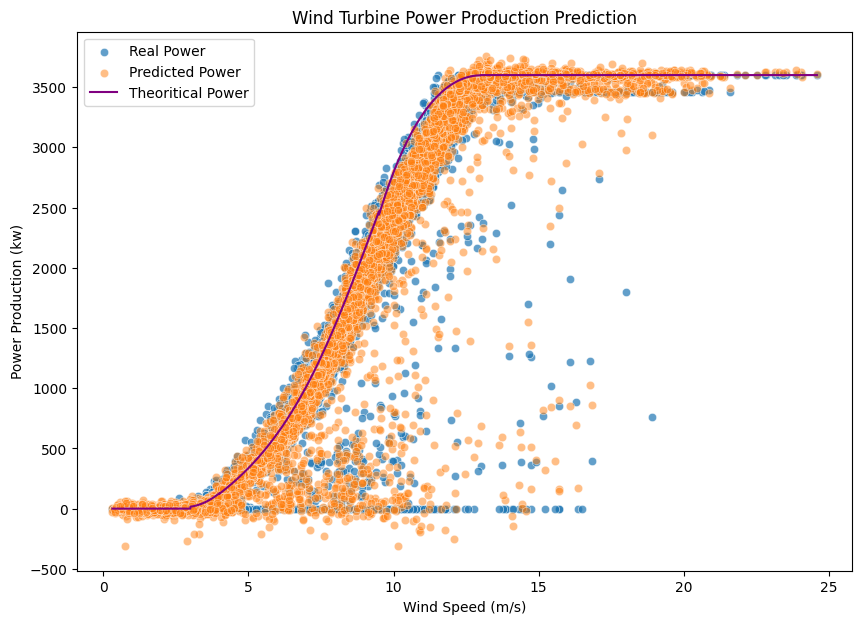

In [62]:
from typing import TYPE_CHECKING
if TYPE_CHECKING:
    import pandas as pd
    data_new: pd.DataFrame = pd.DataFrame()

# Visualizing real, theoritical and predicted power production
plt.figure(figsize=(10,7))
sns.scatterplot(x=df['Wind Speed (m/s)'], y=data_new['LV ActivePower (kW)'],alpha=0.7, label= 'Real Power')
sns.scatterplot(x=df['Wind Speed (m/s)'], y=data_new['Predictions'], alpha=0.5, label='Predicted Power', marker='o')
sns.lineplot(x=df['Wind Speed (m/s)'], y=data_new["Theoretical_Power_Curve (KWh)"], label='Theoritical Power',color='purple')
plt.title('Wind Turbine Power Production Prediction')
plt.ylabel('Power Production (kw)')
plt.legend()

Calculating prediction error...
Training GMM to learn the structure of the error distribution...
GMM has successfully learned parameters of the two Gaussian components.

=> Learned anomaly threshold (from GMM): 124.38 kW



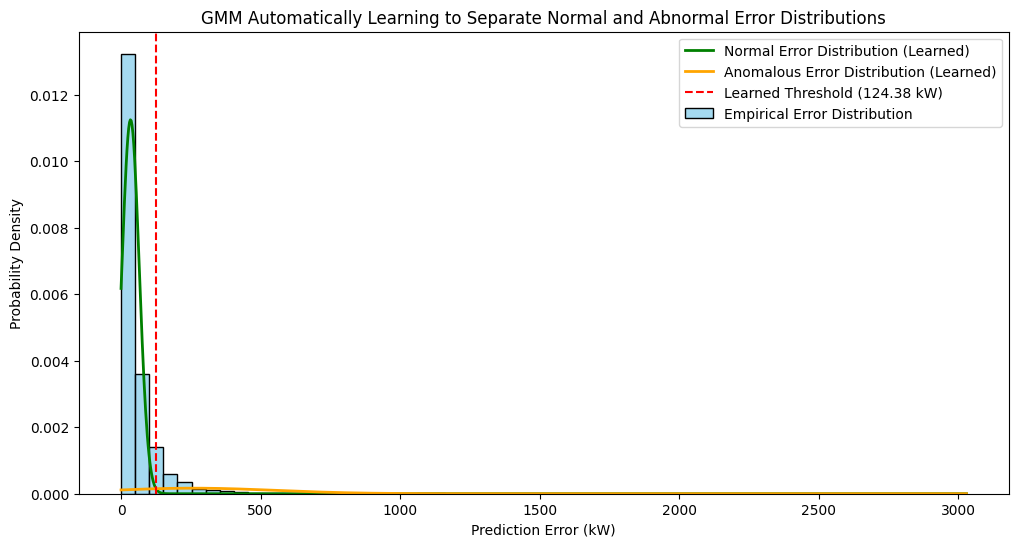


Detected 1099 anomalous data points using the learned threshold.



,LV ActivePower (kW),Predictions,Theoretical_Power_Curve (KWh),error
12407,0.000000,3030.470982,3600.000000,3030.470982
10378,0.000000,2960.266692,3600.000000,2960.266692
30187,0.000000,2463.660496,3535.324070,2463.660496
8763,757.390015,3106.181044,3600.000000,2348.791029
7621,0.000000,2296.346604,3485.057344,2296.346604
...,...,...,...,...
34871,1347.259033,1471.929348,1579.234353,124.670315
47484,1685.508057,1560.904927,1524.101012,124.603130
38594,1227.505981,1102.923047,848.415158,124.582934
30345,3318.183105,3442.739002,3571.137210,124.555896



List of detected anomalous points with corresponding timestamps:


,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°),Predictions,error
12407,01 04 2018 15:50,0.000000,16.504589,3600.000000,224.264801,3030.470982,3030.470982
10378,18 03 2018 13:40,0.000000,13.889650,3600.000000,214.473404,2960.266692,2960.266692
30187,03 08 2018 21:10,0.000000,12.090480,3535.324070,62.811501,2463.660496,2463.660496
8763,07 03 2018 08:20,757.390015,18.901560,3600.000000,221.477600,3106.181044,2348.791029
7621,27 02 2018 10:00,0.000000,11.787960,3485.057344,213.849396,2296.346604,2296.346604
...,...,...,...,...,...,...,...
34871,05 09 2018 15:50,1347.259033,8.085331,1579.234353,28.777981,1471.929348,124.670315
47484,10 12 2018 18:40,1685.508057,7.989695,1524.101012,37.906151,1560.904927,124.603130
38594,06 10 2018 05:40,1227.505981,6.606827,848.415158,96.846657,1102.923047,124.582934
30345,04 08 2018 23:30,3318.183105,12.402780,3571.137210,62.878071,3442.739002,124.555896


In [63]:
from sklearn.mixture import GaussianMixture
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- STEP 1: Compute Prediction Error ---
print("Calculating prediction error...")
data_new['error'] = abs(data_new['LV ActivePower (kW)'] - data_new['Predictions'])

# --- STEP 2: Learn the Error Distribution using Gaussian Mixture Model (GMM) ---
print("Training GMM to learn the structure of the error distribution...")

# GMM requires a 2D array as input
error_data = data_new['error'].values.reshape(-1, 1)

# Initialize a GMM with two components: one for normal, one for anomalous errors
gmm = GaussianMixture(n_components=2, random_state=42)
gmm.fit(error_data)

print("GMM has successfully learned parameters of the two Gaussian components.")

# --- STEP 3: Determine the Optimal Threshold (Intersection of the Two Gaussians) ---

# Extract learned parameters
means = gmm.means_.flatten()
covs = gmm.covariances_.flatten()
weights = gmm.weights_.flatten()

# Sort by mean: first is 'normal' (low error), second is 'anomalous' (high error)
sorted_indices = np.argsort(means)
normal_idx, anomaly_idx = sorted_indices[0], sorted_indices[1]

# Generate a range of error values for curve plotting
x = np.linspace(error_data.min(), error_data.max(), 1000)

# Compute PDFs for both Gaussians
pdf_normal = norm.pdf(x, means[normal_idx], np.sqrt(covs[normal_idx])) * weights[normal_idx]
pdf_anomaly = norm.pdf(x, means[anomaly_idx], np.sqrt(covs[anomaly_idx])) * weights[anomaly_idx]

# Find intersection point between the two Gaussian probability curves
intersection_idx = np.argwhere(np.diff(np.sign(pdf_normal - pdf_anomaly))).flatten()
learned_threshold = x[intersection_idx][0]

print(f"\n=> Learned anomaly threshold (from GMM): {learned_threshold:.2f} kW\n")

# --- STEP 4: Visualization of the Learned Model ---
plt.figure(figsize=(12, 6))
sns.histplot(data_new['error'], bins=60, kde=False, stat='density',
             color='skyblue', label='Empirical Error Distribution')
plt.plot(x, pdf_normal, color='green', linewidth=2, label='Normal Error Distribution (Learned)')
plt.plot(x, pdf_anomaly, color='orange', linewidth=2, label='Anomalous Error Distribution (Learned)')
plt.axvline(learned_threshold, color='red', linestyle='--',
            label=f'Learned Threshold ({learned_threshold:.2f} kW)')
plt.legend()
plt.title("GMM Automatically Learning to Separate Normal and Abnormal Error Distributions")
plt.xlabel("Prediction Error (kW)")
plt.ylabel("Probability Density")
plt.show()

# --- STEP 5: Detect Anomalies based on the Learned Threshold ---
anomalies = data_new[data_new['error'] > learned_threshold]

print(f"\nDetected {len(anomalies)} anomalous data points using the learned threshold.\n")

# Display key information
anomalies_sorted = anomalies.sort_values(by='error', ascending=False)
columns_to_display = ['LV ActivePower (kW)', 'Predictions',
                      'Theoretical_Power_Curve (KWh)', 'error']
display(anomalies_sorted[columns_to_display])

# Merge with timestamps for further investigation
anomaly_indices = anomalies.index
anomalies_with_time = df_copy_test.loc[anomaly_indices].join(anomalies[['Predictions', 'error']])

print("\nList of detected anomalous points with corresponding timestamps:")
display(anomalies_with_time.sort_values(by='error', ascending=False))


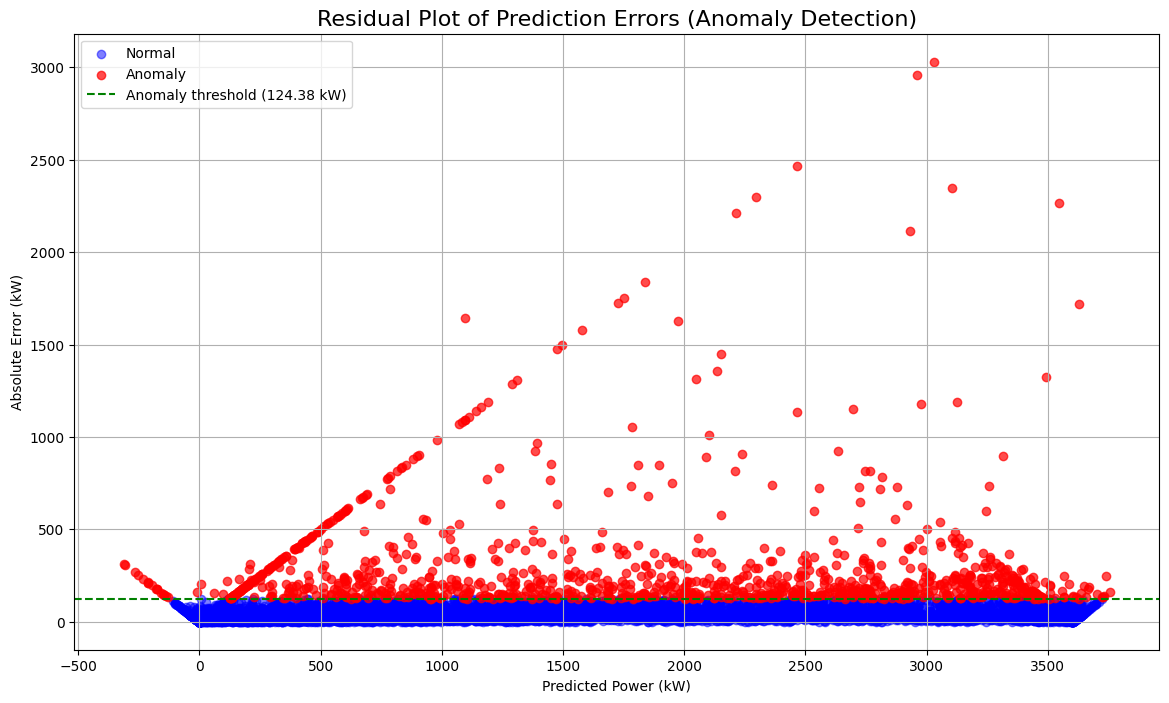

In [64]:
# --- FLAG ANOMALIES ---
anomaly_indices = anomalies.index

# 1. Create a new column 'is_anomaly' and set all values to 0 (normal)
data_new['is_anomaly'] = 0

# 2. Mark anomalous rows with value 1
data_new.loc[anomaly_indices, 'is_anomaly'] = 1

# --- PLOTTING SECTION ---
plt.figure(figsize=(14, 8))

# Split the data
normal_data = data_new[data_new['is_anomaly'] == 0]
anomaly_data = data_new[data_new['is_anomaly'] == 1]

# Plot normal points (blue)
plt.scatter(normal_data['Predictions'], normal_data['error'],
            color='blue', alpha=0.5, label='Normal')

# Plot anomalies (red)
plt.scatter(anomaly_data['Predictions'], anomaly_data['error'],
            color='red', alpha=0.7, label='Anomaly')

# Plot the anomaly threshold line
plt.axhline(y=learned_threshold, color='green', linestyle='--',
            label=f'Anomaly threshold ({learned_threshold:.2f} kW)')

# Chart formatting
plt.title("Residual Plot of Prediction Errors (Anomaly Detection)", fontsize=16)
plt.xlabel("Predicted Power (kW)")
plt.ylabel("Absolute Error (kW)")
plt.legend()
plt.grid(True)
plt.show()


In [65]:
# 'anomalies' là DataFrame chứa 800 điểm bất thường của bạn

# Nhóm 1: Các bất thường RÕ RÀNG (có gió, không công suất)
obvious_anomalies = anomalies[anomalies['LV ActivePower (kW)'] == 0]

# Nhóm 2: Các bất thường TINH VI (kém hiệu quả)
subtle_anomalies = anomalies[anomalies['LV ActivePower (kW)'] > 0]

print(f"Trong số {len(anomalies)} điểm bất thường:")
print(f"- Có {len(obvious_anomalies)} điểm là bất thường rõ ràng (ví dụ: bảo trì).")
print(f"- Có {len(subtle_anomalies)} điểm là bất thường tinh vi (kém hiệu quả).")

Trong số 1099 điểm bất thường:
- Có 167 điểm là bất thường rõ ràng (ví dụ: bảo trì).
- Có 932 điểm là bất thường tinh vi (kém hiệu quả).


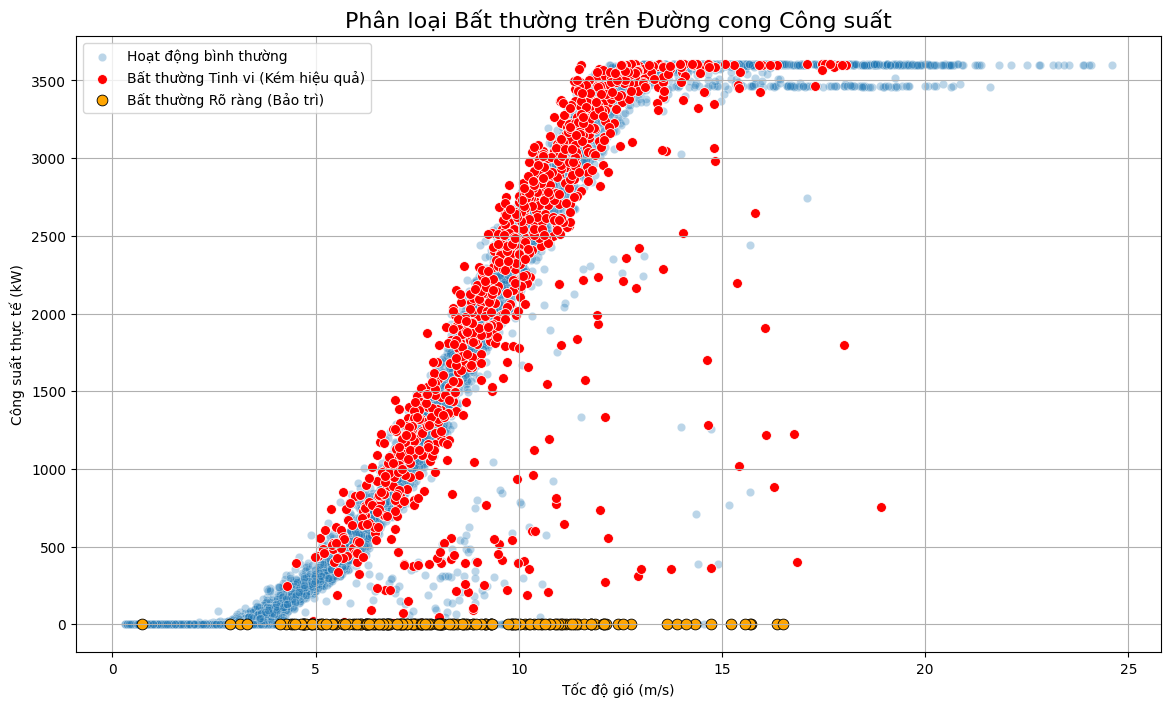

In [66]:
# --- TRỰC QUAN HÓA PHÂN LOẠI BẤT THƯỜNG TRÊN ĐƯỜNG CONG CÔNG SUẤT ---
#
# Mục tiêu: Trực quan hóa ý nghĩa vật lý của từng loại bất thường.
# Biểu đồ này sẽ cho thấy rõ ràng các điểm "rõ ràng" nằm ở đâu và các điểm "tinh vi"
# nằm ở đâu trên đường cong công suất thực tế.

# Chuẩn bị dữ liệu: Thêm cột 'Wind Speed' vào các DataFrame
# (Lưu ý: bạn có thể đã làm bước này ở các cell trước)
if 'Wind Speed (m/s)' not in normal_data.columns:
    normal_data = normal_data.join(X_test['Wind Speed (m/s)'])
if 'Wind Speed (m/s)' not in subtle_anomalies.columns:
    subtle_anomalies = subtle_anomalies.join(X_test['Wind Speed (m/s)'])
if 'Wind Speed (m/s)' not in obvious_anomalies.columns:
    obvious_anomalies = obvious_anomalies.join(X_test['Wind Speed (m/s)'])

plt.figure(figsize=(14, 8))

# 1. Vẽ các điểm hoạt động bình thường (màu xanh nhạt)
sns.scatterplot(x='Wind Speed (m/s)', y='LV ActivePower (kW)', data=normal_data,
                alpha=0.3, label='Hoạt động bình thường')

# 2. Vẽ các điểm bất thường TINH VI (màu đỏ)
sns.scatterplot(x='Wind Speed (m/s)', y='LV ActivePower (kW)', data=subtle_anomalies,
                color='red', s=50, label='Bất thường Tinh vi (Kém hiệu quả)')

# 3. Vẽ các điểm bất thường RÕ RÀNG (màu cam)
sns.scatterplot(x='Wind Speed (m/s)', y='LV ActivePower (kW)', data=obvious_anomalies,
                color='orange', s=60, edgecolor='black', label='Bất thường Rõ ràng (Bảo trì)')


plt.title('Phân loại Bất thường trên Đường cong Công suất', fontsize=16)
plt.xlabel('Tốc độ gió (m/s)')
plt.ylabel('Công suất thực tế (kW)')
plt.legend()
plt.grid(True)
plt.show()

<a name="7"></a>
# 7 - Plot Predicted/Real/Theoritical Power

In [67]:
# from typing import TYPE_CHECKING
# if TYPE_CHECKING:
#     import pandas as pd
#     data_new: pd.DataFrame = pd.DataFrame()

# # Visualizing real, theoritical and predicted power production
# plt.figure(figsize=(10,7))
# sns.scatterplot(x=df['Wind Speed (m/s)'], y=data_new['LV ActivePower (kW)'],alpha=0.7, label= 'Real Power')
# sns.scatterplot(x=df['Wind Speed (m/s)'], y=data_new['Predictions'], alpha=0.5, label='Predicted Power', marker='o')
# sns.lineplot(x=df['Wind Speed (m/s)'], y=data_new["Theoretical_Power_Curve (KWh)"], label='Theoritical Power',color='purple')
# plt.title('Wind Turbine Power Production Prediction')
# plt.ylabel('Power Production (kw)')
# plt.legend()

the model fits better to the real power production, than the theoritical power production curve.

--- ANALYSIS RESULTS FOR THE FIRST 20 TEST POINTS ---
(Includes both normal and anomalous points)



,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Predictions,error,is_anomaly
8057,02 03 2018 10:40,3348.910889,11.632760,2938.990694,409.920194,1
8059,02 03 2018 11:00,2647.506104,10.345970,2725.871209,78.365106,0
50250,30 12 2018 01:20,0.000000,6.430618,37.701979,37.701979,0
14774,18 04 2018 04:50,1334.573975,7.952174,1280.129086,54.444889,0
49374,23 12 2018 23:20,533.002808,5.906481,531.850327,1.152481,0
22716,12 06 2018 17:30,2496.370117,10.835030,2649.533154,153.163036,1
26364,08 07 2018 07:30,1071.803955,7.452403,1079.950876,8.146921,0
49234,23 12 2018 00:00,3587.481934,12.707970,3573.439816,14.042118,0
11993,29 03 2018 18:50,450.298004,5.784743,492.335621,42.037617,0
15125,20 04 2018 15:20,3387.311035,11.773680,3443.551402,56.240367,0




--- SUMMARY PLOT: ANOMALY CLASSIFICATION ON THE POWER CURVE ---


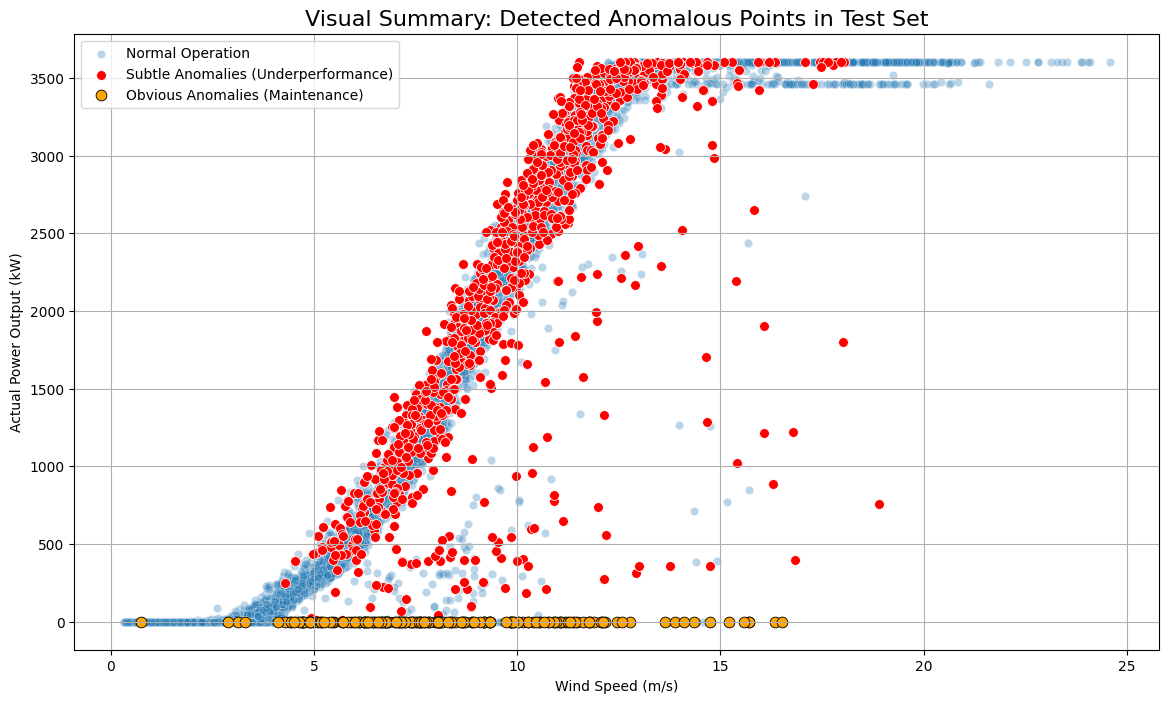



--- STAGE 1 SUMMARY ---
Total data points in test set: 10106
Total detected anomalous points: 1099
Percentage of anomalies detected: 10.87%


In [68]:
# --- 1. BUILD FULL TEST RESULTS DATAFRAME ---
full_test_results_df = df_copy_test.copy()
full_test_results_df['Predictions'] = data_new['Predictions']
full_test_results_df['error'] = data_new['error']
full_test_results_df['is_anomaly'] = data_new['is_anomaly']

# --- 2. DISPLAY RESULTS FOR THE FIRST 20 TEST POINTS ---
print("--- ANALYSIS RESULTS FOR THE FIRST 20 TEST POINTS ---")
print("(Includes both normal and anomalous points)\n")

# <--- MAJOR CHANGE HERE --->
# Instead of filtering and sorting, we simply take the first 20 rows
first_20_results = full_test_results_df.head(20)

# Select columns to display
columns_to_show = ['Date/Time', 'LV ActivePower (kW)', 'Wind Speed (m/s)',
                   'Predictions', 'error', 'is_anomaly']

display(first_20_results[columns_to_show])


# --- 3. VISUALIZE OVERALL ANOMALY DETECTION RESULTS ---
# (This section remains unchanged; it still operates on the entire test set)
print("\n\n--- SUMMARY PLOT: ANOMALY CLASSIFICATION ON THE POWER CURVE ---")

normal_data_plot = full_test_results_df[full_test_results_df['is_anomaly'] == 0]
anomalies_plot = full_test_results_df[full_test_results_df['is_anomaly'] == 1]
obvious_anomalies_plot = anomalies_plot[anomalies_plot['LV ActivePower (kW)'] == 0]
subtle_anomalies_plot = anomalies_plot[anomalies_plot['LV ActivePower (kW)'] > 0]

plt.figure(figsize=(14, 8))
sns.scatterplot(x='Wind Speed (m/s)', y='LV ActivePower (kW)', data=normal_data_plot, alpha=0.3, label='Normal Operation')
sns.scatterplot(x='Wind Speed (m/s)', y='LV ActivePower (kW)', data=subtle_anomalies_plot, color='red', s=50, label='Subtle Anomalies (Underperformance)')
sns.scatterplot(x='Wind Speed (m/s)', y='LV ActivePower (kW)', data=obvious_anomalies_plot, color='orange', s=60, edgecolor='black', label='Obvious Anomalies (Maintenance)')

plt.title('Visual Summary: Detected Anomalous Points in Test Set', fontsize=16)
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Actual Power Output (kW)')
plt.legend()
plt.grid(True)
plt.show()


# --- 4. NUMERICAL SUMMARY OF RESULTS ---
# (This part remains unchanged; it still calculates metrics on the entire test set)
total_points_in_test_set = len(y_test)
total_anomalies_found = full_test_results_df['is_anomaly'].sum()
percentage_of_anomalies = (total_anomalies_found / total_points_in_test_set) * 100

print("\n\n" + "="*40)
print("--- STAGE 1 SUMMARY ---")
print(f"Total data points in test set: {total_points_in_test_set}")
print(f"Total detected anomalous points: {total_anomalies_found}")
print(f"Percentage of anomalies detected: {percentage_of_anomalies:.2f}%")
print("="*40)


In [69]:
# === CELL CUỐI CÙNG TRONG NOTEBOOK 1 ===

# Lưu các bộ dữ liệu đã được tiền xử lý thành công
X_1_train_f1.to_csv('processed_X_train.csv', index=False)
y_train.to_csv('processed_y_train.csv', index=False)
X_1_test_f1.to_csv('processed_X_test.csv', index=False)
y_test.to_csv('processed_y_test.csv', index=False)

# print("Đã lưu thành công 4 file dữ liệu đã xử lý!")